In [100]:
!python3 --version

Python 3.10.12


# **Download data**

In [101]:
%%capture test
!wget 'https://drive.google.com/uc?export=download&id=1LV_kUVFsz5eN0lul1jNVjVX6lpChNU9B' -O 'dataset.zip'
!unzip -o dataset.zip -d 'data'


# **Setup env**

In [102]:
!pip install -r req.txt

In [103]:
!python3 -m nltk.downloader wordnet
!unzip /root/nltk_data/corpora/wordnet.zip -d /root/nltk_data/corpora/

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package wordnet to /home/mike/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
unzip:  cannot find or open /root/nltk_data/corpora/wordnet.zip, /root/nltk_data/corpora/wordnet.zip.zip or /root/nltk_data/corpora/wordnet.zip.ZIP.


In [104]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 6.8 MB/s eta 0:00:0000:0100:01m
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


Раскоментить если на Kaggle

In [105]:
# import nltk 

# import subprocess
# try:
#     nltk.data.find('wordnet.zip')
# except:
#     nltk.download('wordnet', download_dir='/kaggle/working/')
#     command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
#     subprocess.run(command.split())
#     nltk.data.path.append('/kaggle/working/')

# **Imports**

In [106]:
import numpy as np # linear algebra
import pandas as pd
import os
from bs4 import BeautifulSoup
import re
import mailparser
from string import punctuation
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from gensim.models import Word2Vec
from sklearn.metrics import classification_report, confusion_matrix
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import spacy
from random import choice
from IPython.display import display, HTML
import nltk 

In [107]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/mike/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [182]:
import warnings
warnings.filterwarnings('ignore')


# **Global vars**

In [108]:
spam_data_path = './data/spam/'
ham_data_path = './data/ham/'
spam_data = list(map(lambda a: spam_data_path + a, os.listdir(spam_data_path)))
ham_data = list(map(lambda a: ham_data_path + a, os.listdir(ham_data_path)))
stop_symbols = punctuation.replace('?', '').replace('!', '').replace('.', '')
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_md")


In [109]:
len(spam_data), len(ham_data)

(1397, 2551)

В данных присутствует дизбаланс классов.

# **Global functions**

In [110]:
def readDataFromFile(path):
    with open(path, 'r') as f:
        d = f.read()
    return d


def cleanersPipeline(text: str, cleaners: list):
    for cleaner in cleaners:
        text = cleaner(text)
    return text


# **First lookup**

Для более удобной работы с письмами (и что-бы не писать свой парсер) будем использовать библиотеку `mail-parser`. Благодаря ему мы можем выделять только тело письма.

In [111]:
mail = mailparser.parse_from_file(spam_data[2])
mail.body

'<html>\n<head>\n<meta http-equiv="Content-Type" content="text/html; charset=windows-1252">\n<meta name="GENERATOR" content="Microsoft FrontPage 4.0">\n<meta name="ProgId" content="FrontPage.Editor.Document">\n<title>Hunza Bread</title>\n</head>\n\n<body>\n<H2>\n<CENTER>Hunza Bread</CENTER></H2>\n<P>Home made Hunza Bread is a simple, delicious and nutritious bread that is easily \nprepared in just 5 minutes  using a few ingredients that have \nalways been universally available. The taste of this bread is wonderful.\n<P>HUNZA BREAD Miraculously Stops Your Appetite And Hunger and is based on a 2000 \nyear old recipe\n<P>The Hunzas are considered to be the healthiest people on earth. This bread is the \nmain part of their diet.\n<P><A href="http://211.117.193.159/bread1/124.html">CLICK HERE</A> to learn more about \nthese  astounding people and their delicious, \nnutritious and easy to prepare home made health bread that suppresses  your appetite. \n</P><p><br>\n\n</body>\n\n</html>\n\n\n

Проверим данные на дубликаты

In [184]:
spam_all = [mailparser.parse_from_file(i).body for i in spam_data]
spam_all_unique = np.unique(spam_all)
len(spam_all), len(spam_all_unique)

More than one match found for (?:(?:^|\s)from\s+(?P<from>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+by|\s+with(?! cipher)|\s+id|\s+for|\s+via|;)) in from autodoors.co.kr 64.40.39.124 by infodental.co.kr 211.240.48.194 with nMail V2.1 2001.03.07 Win32 SMTP Server for <jm@netnoteinc.com> from <rb.ellison@dr.com>; Fri, 29 Jun 2001 19:12:15 +0900
More than one match found for (?:(?:^|\s)from\s+(?P<from>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+by|\s+with(?! cipher)|\s+id|\s+for|\s+via|;)) in from autodoors.co.kr 64.40.39.124 by infodental.co.kr 211.240.48.194 with nMail V2.1 2001.03.07 Win32 SMTP Server for <jm@netnoteinc.com> from <rb.ellison@dr.com>; Fri, 29 Jun 2001 19:12:15 +0900
Email content 'plain charset=us-ascii' not handled
Email content 'alternative' not handled
More than one match found for (?:(?:^|\s)from\s+(?P<from>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+by|\s+with(?! cipher)|\s+id|\s+for|\s+via|;)) in from chekitb5876.com 195.27.92.154 by

(1397, 1277)

In [186]:
ham_all = [mailparser.parse_from_file(i).body for i in ham_data]
ham_all_unique = np.unique(ham_all)
print(len(ham_all), len(ham_all_unique))

Email content 'pgp-signature' not handled


Email content 'pgp-signature' not handled
Email content 'pgp-signature' not handled
Email content 'pgp-signature' not handled
Email content 'pgp-signature' not handled
Email content 'pgp-signature' not handled
Email content 'pgp-signature' not handled
Email content 'pgp-signature' not handled
Email content 'pgp-signature' not handled
Email content 'pgp-signature' not handled
Email content 'pgp-signature' not handled
Email content 'pgp-signature' not handled
More than one match found for (?:with(?! cipher)\s+(?P<with>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+id|\s+for|\s+via|;)) in from unknown HELO ?192.168.0.100? salimma1@212.18.241.211 with plain by smtp.mail.vip.sc5.yahoo.com with SMTP; 10 Oct 2002 10:30:25 -0000
More than one match found for (?:with(?! cipher)\s+(?P<with>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+id|\s+for|\s+via|;)) in from unknown HELO ?192.168.0.100? salimma1@212.18.241.211 with plain by smtp.mail.vip.sc5.yahoo.

2551 2408


Видим наличие дубликатов

В итоге имеем документ с html-вёрсткой. Для удаления тэгов воспользуемся `BeautifulSoup`.

Дата, ip и почта, при отсутствии последовательности поступления писем, будут бесполезны. Так-же как и большинство символов и декаративных элементов - линий.

Напишем функции для отчистки текста от мусора.

In [112]:
# Тэги для заполнения мусора
month_filler = ''
day_of_week_filler = ''
time_filler = ''
mail_filler = ''
date_filler = ''
href_filler = ''
enum_filler = ''
num_filler = ''

# Форматы для фильтров
re_mails = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b')
re_time = re.compile(r'\d+:\d+:\d+')
re_date1 = re.compile(r'\w{3} \d\d \d\d:\d\d:\d\d \d\d\d\d',)
re_date2 = re.compile(r'\d\d \w{3} \d\d\d\d \d\d:\d\d:\d\d',)
re_lines = re.compile(r'[-_=]+')
re_href = re.compile('http[s]?://.+')
re_site = re.compile('\w+\.\w+')

# Фильтры
mail_cleaner = lambda text: re.sub(re_mails, mail_filler, text)
space_cleaner = lambda text: re.sub(r'\s+', ' ', text)
eol_cleaner = lambda text: re.sub(r'\n', '.', text)
time_cleaner = lambda text: re.sub(re_time, time_filler, text)
date_cleaner = lambda text: re.sub(re_date2, date_filler, re.sub(re_date1, '', text))
lines_cleaner = lambda text: re.sub(re_lines, '', text)
href_cleaner = lambda text: re.sub(re_href, href_filler, text)
site_cleaner = lambda text: re.sub(re_site, href_filler, text)
num_cleaner = lambda text: re.sub(r'\d+', num_filler, text)
shorts_cleaner = lambda text: re.sub(r'\w\.', num_filler, text)


def dayOfWeekCleaner(text):
    dow = ['Mon', 'Sat', 'Wed', 'Tues', 'Thurs', 'Fri', 'Sun']
    for i in dow:
        text = text.replace(i, day_of_week_filler)
    return text


def replaceSymbols(text):
    for i in stop_symbols:
        text = text.replace(f' {i} ', ' ')
        text = text.replace(f'{i} ', ' ')
        text = text.replace(f' {i}', ' ')
        text = text.replace(i, ' ')
    text = text.replace('.', '. ')
    text = text.replace('!', '! ')
    text = text.replace('?', '? ')
    return text


def replaceEnums(text):
    text = re.sub(r'\d+th', enum_filler, text)
    text = re.sub(r'\d+st', enum_filler, text)
    text = re.sub(r'\d+th', enum_filler, text)
    text = re.sub(r'\d+nd', enum_filler, text)
    return text


def removeSingle(text):
    return ' '.join([i for i in text.split(' ') if len(i) != 1])


def lower_formator(text):
    return text.lower()


def replaceAllSymbols(text):
    for i in punctuation:
        text = text.replace(i, ' ')
    return text
        


# Создадим стандартную стратегию для нормализации текстов:

- удаляются все символы-пунктуации;
- все слова приводятся к нижнему регистру;
- удаляются все цифры;
- удаляются все сокращения;
- удаляются элементы с длиной 1;
- удаляются почтовые адреса;
- удаляются ссылки на сайты;

In [113]:
std_cleaner_pipline_strategy = [
    href_cleaner, 
    replaceEnums, 
    lines_cleaner, 
    dayOfWeekCleaner, 
    time_cleaner, 
    space_cleaner, 
    mail_cleaner, 
    replaceSymbols, 
    site_cleaner, 
    num_cleaner, 
    shorts_cleaner, 
    removeSingle, 
    space_cleaner, 
    lower_formator
]

Выведим результат

In [114]:
cleanersPipeline(
    BeautifulSoup(mail.body, 'html.parser').text, 
    std_cleaner_pipline_strategy
)

' hunza bread hunza bread home made hunza bread is simple delicious and nutritious bread that is easily prepared in just minutes using few ingredients that have always been universally availabl the taste of this bread is wonderfu hunza bread miraculously stops your appetite and hunger and is based on year old recipe the hunzas are considered to be the healthiest people on eart this bread is the main part of their die click here to learn more about these astounding people and their delicious nutritious and easy to prepare home made health bread that suppresses your appetit '

Т.к. для первого просмотра этого будет достаточно - обернём в функцию.

In [115]:
def stdTextNormalizer(path):
    mail = mailparser.parse_from_file(path)
    text = BeautifulSoup(mail.body, 'html.parser').text
    return cleanersPipeline(
        text, 
        std_cleaner_pipline_strategy
    )

# **Create dataset**

In [116]:
df_with_std_clean = pd.DataFrame({'mails': spam_data + ham_data, 'class': np.ones(len(spam_data)).tolist() + np.zeros(len(ham_data)).tolist()})
df_with_std_clean['texts'] = df_with_std_clean['mails'].map(stdTextNormalizer)
df_with_std_clean

/tmp/ipykernel_312569/3795023322.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(mail.body, 'html.parser').text


More than one match found for (?:(?:^|\s)from\s+(?P<from>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+by|\s+with(?! cipher)|\s+id|\s+for|\s+via|;)) in from autodoors.co.kr 64.40.39.124 by infodental.co.kr 211.240.48.194 with nMail V2.1 2001.03.07 Win32 SMTP Server for <jm@netnoteinc.com> from <rb.ellison@dr.com>; Fri, 29 Jun 2001 19:12:15 +0900
More than one match found for (?:(?:^|\s)from\s+(?P<from>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+by|\s+with(?! cipher)|\s+id|\s+for|\s+via|;)) in from autodoors.co.kr 64.40.39.124 by infodental.co.kr 211.240.48.194 with nMail V2.1 2001.03.07 Win32 SMTP Server for <jm@netnoteinc.com> from <rb.ellison@dr.com>; Fri, 29 Jun 2001 19:12:15 +0900
Email content 'plain charset=us-ascii' not handled
Email content 'alternative' not handled
More than one match found for (?:(?:^|\s)from\s+(?P<from>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+by|\s+with(?! cipher)|\s+id|\s+for|\s+via|;)) in from chekitb5876.com 195.27.92.154 by

,mails,class,texts
0,./data/spam/00969.636d340655d05418edc2d1cd2ca0...,1.0,dear cypherpunks want to harvest lot of email ...
1,./data/spam/00321.00c19304d06d2e9fd068873434f1...,1.0,vigoral ad vigoral herbal sex enhancersdirect...
2,./data/spam/00735.474fd4bc103225c72fd82d88bba4...,1.0,hunza bread hunza bread home made hunza bread...
3,./data/spam/00086.5ddcb4859b292c984d1db6aeade5...,1.0,increase your revenues by accepting credit ca...
4,./data/spam/00531.f3fffa4504c7009a03dd0d44a456...,1.0,finally you too can make ebay into nonstop ca...
...,...,...,...
3943,./data/ham/1517.14cf0162b6bf5274305b7b573a0c3a82,0.0,anthony baxter wrote currently mangling it by...
3944,./data/ham/1010.1bc4545387a6a526b351a330b4aca16c,0.0,no analysis ye don know what to make of it ye ...
3945,./data/ham/0993.e9b2fa685c22a3f2977985514c78d9e8,0.0,whore eructed it an amusing anecdote don know ...
3946,./data/ham/2050.24cc1daa8d252a81f59a09e8f69e9c71,0.0,url date img


Выберим датасет для первого прогона

In [117]:
df = df_with_std_clean.copy().drop_duplicates('texts')
df.shape

(3481, 3)

# **Deeper research**

Рассмотрим информацию о размере словаря

In [118]:
d = sum(df['texts'].apply(lambda a: a.split()).apply(lambda a: list(filter(lambda b: len(b) > 0, a))).to_list(), [])
n = pd.Series(d).value_counts()
n.describe()

count    41838.000000
mean        19.528156
std        306.633509
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      35782.000000
Name: count, dtype: float64

In [119]:
n[(n < 8000) & (n>100)].describe()

count     965.000000
mean      431.282902
std       766.335431
min       101.000000
25%       134.000000
50%       202.000000
75%       363.000000
max      7935.000000
Name: count, dtype: float64

<Axes: >

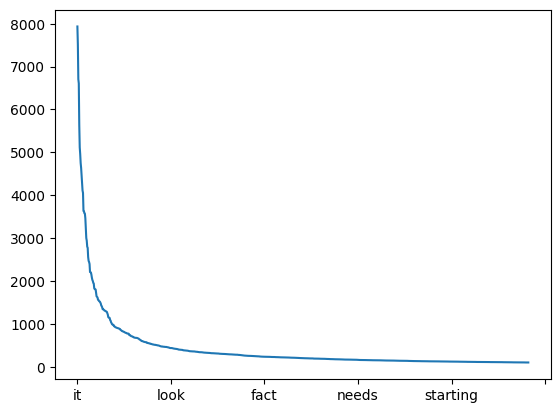

In [120]:
n[(n < 8000) & (n>100)].plot()

# **Model selection**

## Train test split

Разделим данные на тренеровочную и тестовую. Для невилирования возможности переобучения укажем параметр `stratify`

In [121]:
X_train, X_test, y_train, y_test = train_test_split(df['texts'], df['class'], test_size=0.3, stratify=df['class'])

## Vectorizer

Выберем метод векторизации текстов.

Т.к. язык у нас английский, то задача становится сильно проще и использование сложных моделей (в том числе и моделей векторизации) будет избыточно. Поэтому проверим первую стратегию векторизции текстов - векторизуем все слова и ищем среднее значение по каждому параметру.

Для данной задачи была выбранна модель Word2Vec. Но стоит учесть, что слова не находящиеся в словаре данной модели будут векторизованны лиш как [UNK] тэг

In [122]:
w2v_model = Word2Vec(sentences=X_train.map(lambda a: a.split(' ')).to_list(), vector_size=256, window=5, min_count=1, workers=4)

In [123]:
unk_word = np.zeros(256)

In [124]:
def vectorizerByW2V(word):
    try:
        return w2v_model.wv[word]
    except:
        return unk_word
    

## Prepear data to models

In [125]:
def textEmbedingByMeanPooling(data, model):
    x = list()
    for text in data:
        v = None
        k = 0
        for word in text.split(' '):
            if k==0:
                v = model(word).copy()
            else:
                v += model(word).copy()
            k+=1
        v = v/k
        x.append(v.tolist())
    return np.array(x)
            
            

In [126]:
x_train_prep = textEmbedingByMeanPooling(X_train, vectorizerByW2V)
x_train_prep.shape, x_train_prep.dtype

((2436, 256), dtype('float64'))

In [127]:
x_test_prep = textEmbedingByMeanPooling(X_test, vectorizerByW2V)
x_test_prep.shape, x_test_prep.dtype

((1045, 256), dtype('float64'))

## Model

In [128]:
catboost_model = CatBoostClassifier(iterations=100,
#  task_type="GPU",
#  devices='0:1'
)
catboost_model.fit(x_train_prep,
          y_train,
          verbose=False)

In [129]:
print(classification_report(y_train, catboost_model.predict(x_train_prep)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1649
         1.0       1.00      1.00      1.00       787

    accuracy                           1.00      2436
   macro avg       1.00      1.00      1.00      2436
weighted avg       1.00      1.00      1.00      2436



Казалось-бы получили переобучение

In [130]:
print(classification_report(y_test, catboost_model.predict(x_test_prep)))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       708
         1.0       0.94      0.96      0.95       337

    accuracy                           0.97      1045
   macro avg       0.96      0.97      0.97      1045
weighted avg       0.97      0.97      0.97      1045



А нет-с

In [131]:
confusion_matrix(y_test, catboost_model.predict(x_test_prep))

array([[689,  19],
       [ 12, 325]])

В принципе уже не плохо. Сохраним модель и попытаемся добить до 99.


In [132]:
catboost_model.save_model("model.cbm")

In [133]:
w2v_model.save('vecctorizer.w2v')

# **Level up**

## Изменим стратегию нормализации текстов

Воспользуемс `nltk` для лематизации и токенизации текстов

In [134]:
nltk_cleaner_pipline_strategy = [
    href_cleaner, 
    replaceEnums, 
    lines_cleaner, 
    dayOfWeekCleaner, 
    time_cleaner, 
    space_cleaner, 
    mail_cleaner, 
    site_cleaner, 
    num_cleaner, 
    shorts_cleaner, 
    removeSingle, 
    space_cleaner, 
    lower_formator
]

In [135]:
def nltkTextNormalization(path):
    mail = mailparser.parse_from_file(path)
    text = BeautifulSoup(mail.body, 'html.parser').text
    text = cleanersPipeline(
        text, 
        nltk_cleaner_pipline_strategy
    )
    text = ' '.join([lemmatizer.lemmatize(i) for i in word_tokenize(text)])
    for i in punctuation:
        text = text.replace(i, '')
    text = space_cleaner(text)
    return removeSingle(text)


In [136]:
nltkTextNormalization(spam_data[0])

'dear cypherpunks want to harvest lot of email address in very short time easy email searcher is powerful email software that harvest general email list from mail server easy email searcher can get email address directly from the email server in only one hour easy email searcher is bit window program for email marketin it is intended for easy and convenient search large email address list from mail server the program can be operated on window me and easy email searcher support multithreads up to connection easy email searcher ha the ability to reconnect to the mail server if the server ha disconnected and continue the searching at the point where it ha been interrupte easy email searcher ha an ergonomic interface that is easy to set up and simple to easy email searcher is an email address searcher and bulk email sende it can verify more than email address per minute at only kbps spee it even allows you send email to valid email address while searchin you can save the searching progress

In [137]:
df_with_nltk_normalization = pd.DataFrame({'mails': spam_data + ham_data, 'class': np.ones(len(spam_data)).tolist() + np.zeros(len(ham_data)).tolist()})
df_with_nltk_normalization['texts'] = df_with_nltk_normalization['mails'].map(nltkTextNormalization)
df_with_nltk_normalization

/tmp/ipykernel_312569/1258180473.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(mail.body, 'html.parser').text
More than one match found for (?:(?:^|\s)from\s+(?P<from>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+by|\s+with(?! cipher)|\s+id|\s+for|\s+via|;)) in from autodoors.co.kr 64.40.39.124 by infodental.co.kr 211.240.48.194 with nMail V2.1 2001.03.07 Win32 SMTP Server for <jm@netnoteinc.com> from <rb.ellison@dr.com>; Fri, 29 Jun 2001 19:12:15 +0900
More than one match found for (?:(?:^|\s)from\s+(?P<from>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+by|\s+with(?! cipher)|\s+id|\s+for|\s+via|;)) in from autodoors.co.kr 64.40.39.124 by infodental.co.kr 211.240.48.194 with nMail V2.1 2001.03.07 Win32 SMTP Server for <jm@netnoteinc.com> from <rb.ellison@dr.com>; Fri, 29 Jun 2001 19:12:15 +0900
Email content 'plain charset=us-ascii'

,mails,class,texts
0,./data/spam/00969.636d340655d05418edc2d1cd2ca0...,1.0,dear cypherpunks want to harvest lot of email ...
1,./data/spam/00321.00c19304d06d2e9fd068873434f1...,1.0,vigoral ad vigoral herbal sex enhancersdirect ...
2,./data/spam/00735.474fd4bc103225c72fd82d88bba4...,1.0,hunza bread hunza bread home made hunza bread ...
3,./data/spam/00086.5ddcb4859b292c984d1db6aeade5...,1.0,increase your revenue by accepting credit card...
4,./data/spam/00531.f3fffa4504c7009a03dd0d44a456...,1.0,finally you too can make ebay into nonstop ca...
...,...,...,...
3943,./data/ham/1517.14cf0162b6bf5274305b7b573a0c3a82,0.0,anthony baxter wrote currently mangling it by...
3944,./data/ham/1010.1bc4545387a6a526b351a330b4aca16c,0.0,no analysis ye do nt know what to make of it y...
3945,./data/ham/0993.e9b2fa685c22a3f2977985514c78d9e8,0.0,whore eructed it an amusing anecdote do nt kno...
3946,./data/ham/2050.24cc1daa8d252a81f59a09e8f69e9c71,0.0,url date img


In [138]:
d = sum(df_with_nltk_normalization['texts'].apply(lambda a: a.split()).apply(lambda a: list(filter(lambda b: len(b) > 0, a))).to_list(), [])
n = pd.Series(d).value_counts()
n.describe()

count    35976.000000
mean        24.716950
std        364.769622
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max      38730.000000
Name: count, dtype: float64

In [139]:
n[(n < 8000) & (n>100)].describe()

count    1082.000000
mean      441.265250
std       744.023995
min       101.000000
25%       136.000000
50%       208.000000
75%       399.500000
max      7685.000000
Name: count, dtype: float64

<Axes: >

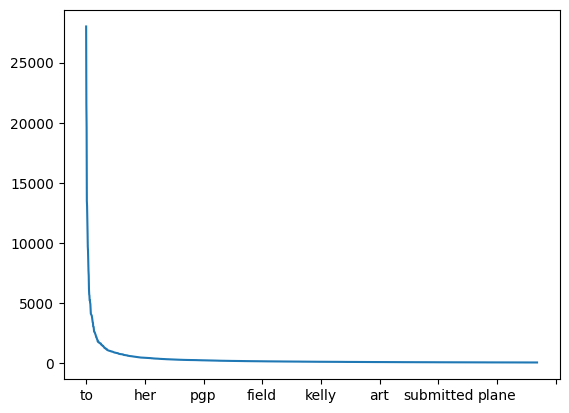

In [140]:
n[(n < 30000) & (n>50)].plot()

In [141]:
usefull_words = n[(n < 8000) & (n>100)].index.to_list()

def uselessWordsRemover(text):
    for i in text.split(' '):
        if not (text in usefull_words):
            text = text.replace(i, '')
    return space_cleaner(text)

In [142]:
df_with_nltk_normalization['texts_for_vec'] = df_with_nltk_normalization['texts'].map(uselessWordsRemover)

In [143]:
df_with_nltk_normalization

,mails,class,texts,texts_for_vec
0,./data/spam/00969.636d340655d05418edc2d1cd2ca0...,1.0,dear cypherpunks want to harvest lot of email ...,stw lt ww market tended lt ww multhreads cnec...
1,./data/spam/00321.00c19304d06d2e9fd068873434f1...,1.0,vigoral ad vigoral herbal sex enhancersdirect ...,r r ly r ual r ual d err subscrir busess k sr...
2,./data/spam/00735.474fd4bc103225c72fd82d88bba4...,1.0,hunza bread hunza bread home made hunza bread ...,mute usg grent th s csidered th ma ir se asun...
3,./data/spam/00086.5ddcb4859b292c984d1db6aeade5...,1.0,increase your revenue by accepting credit card...,master y ir ferg f master f bsite ste stefron...
4,./data/spam/00531.f3fffa4504c7009a03dd0d44a456...,1.0,finally you too can make ebay into nonstop ca...,ful r s dc ar se credible pg ma venry fd fd e...
...,...,...,...,...
3943,./data/ham/1517.14cf0162b6bf5274305b7b573a0c3a82,0.0,anthony baxter wrote currently mangling it by...,count sopid ir or do night n multi no o
3944,./data/ham/1010.1bc4545387a6a526b351a330b4aca16c,0.0,no analysis ye do nt know what to make of it y...,kw b rey roh techlogy specificy soluti a stre...
3945,./data/ham/0993.e9b2fa685c22a3f2977985514c78d9e8,0.0,whore eructed it an amusing anecdote do nt kno...,ecte hg suppt auive y ectal utterce perny ubt...
3946,./data/ham/2050.24cc1daa8d252a81f59a09e8f69e9c71,0.0,url date img,


In [144]:
df = df_with_nltk_normalization.copy().drop_duplicates('texts_for_vec')
df.shape

(3114, 4)

In [145]:
X_train_nltk, X_test_nltk, y_train_nltk, y_test_nltk = train_test_split(df['texts'], df['class'], test_size=0.3, stratify=df['class'])

In [146]:
w2v_nltk_model = Word2Vec(sentences=df['texts_for_vec'].map(lambda a: a.split(' ')).to_list(), vector_size=128, window=5, min_count=1, workers=4)

In [147]:
unk_word = np.zeros(128)
def vectorizerByNLTKW2V(word):
    try:
        return w2v_nltk_model.wv[word]
    except:
        return unk_word
    

In [148]:
x_train_nltk_prep = textEmbedingByMeanPooling(X_train_nltk, vectorizerByNLTKW2V)
x_test_nltk_prep = textEmbedingByMeanPooling(X_test_nltk, vectorizerByNLTKW2V)


In [149]:
catboost_nltk_model = CatBoostClassifier(iterations=100,
#  task_type="GPU",
#  devices='0:1'
)
catboost_nltk_model.fit(x_train_nltk_prep,
          y_train_nltk,
          verbose=False)

In [150]:
print(classification_report(y_test_nltk, catboost_nltk_model.predict(x_test_nltk_prep)))

              precision    recall  f1-score   support

         0.0       0.79      0.90      0.84       636
         1.0       0.69      0.49      0.58       299

    accuracy                           0.77       935
   macro avg       0.74      0.70      0.71       935
weighted avg       0.76      0.77      0.76       935



In [151]:
confusion_matrix(y_test_nltk, catboost_nltk_model.predict(x_test_nltk_prep))

array([[571,  65],
       [151, 148]])

Результат ухудшился $\Rightarrow$ уменьшать вокабуляр бессмысленно (по крайне мере основываясь на частоте встречаемости слов (распределении слов))

## Изменим векторизатор

Воспользуемся `Spacy`

In [152]:
df_with_std_clean = pd.DataFrame({'mails': spam_data + ham_data, 'class': np.ones(len(spam_data)).tolist() + np.zeros(len(ham_data)).tolist()})
df_with_std_clean['texts'] = df_with_std_clean['mails'].map(stdTextNormalizer)
df_with_std_clean

/tmp/ipykernel_312569/3795023322.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(mail.body, 'html.parser').text
More than one match found for (?:(?:^|\s)from\s+(?P<from>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+by|\s+with(?! cipher)|\s+id|\s+for|\s+via|;)) in from autodoors.co.kr 64.40.39.124 by infodental.co.kr 211.240.48.194 with nMail V2.1 2001.03.07 Win32 SMTP Server for <jm@netnoteinc.com> from <rb.ellison@dr.com>; Fri, 29 Jun 2001 19:12:15 +0900
More than one match found for (?:(?:^|\s)from\s+(?P<from>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+by|\s+with(?! cipher)|\s+id|\s+for|\s+via|;)) in from autodoors.co.kr 64.40.39.124 by infodental.co.kr 211.240.48.194 with nMail V2.1 2001.03.07 Win32 SMTP Server for <jm@netnoteinc.com> from <rb.ellison@dr.com>; Fri, 29 Jun 2001 19:12:15 +0900
Email content 'plain charset=us-ascii'

,mails,class,texts
0,./data/spam/00969.636d340655d05418edc2d1cd2ca0...,1.0,dear cypherpunks want to harvest lot of email ...
1,./data/spam/00321.00c19304d06d2e9fd068873434f1...,1.0,vigoral ad vigoral herbal sex enhancersdirect...
2,./data/spam/00735.474fd4bc103225c72fd82d88bba4...,1.0,hunza bread hunza bread home made hunza bread...
3,./data/spam/00086.5ddcb4859b292c984d1db6aeade5...,1.0,increase your revenues by accepting credit ca...
4,./data/spam/00531.f3fffa4504c7009a03dd0d44a456...,1.0,finally you too can make ebay into nonstop ca...
...,...,...,...
3943,./data/ham/1517.14cf0162b6bf5274305b7b573a0c3a82,0.0,anthony baxter wrote currently mangling it by...
3944,./data/ham/1010.1bc4545387a6a526b351a330b4aca16c,0.0,no analysis ye don know what to make of it ye ...
3945,./data/ham/0993.e9b2fa685c22a3f2977985514c78d9e8,0.0,whore eructed it an amusing anecdote don know ...
3946,./data/ham/2050.24cc1daa8d252a81f59a09e8f69e9c71,0.0,url date img


In [153]:
df = df_with_std_clean.copy().drop_duplicates('texts')
df.shape

(3481, 3)

In [154]:
from tqdm import tqdm
tqdm.pandas()

In [155]:
X_train, X_test, y_train, y_test = train_test_split(df['texts'], df['class'], test_size=0.3, stratify=df['class'])
x_test_spacy_prep = X_test.progress_map(lambda a: nlp(a).vector)
x_train_spacy_prep = X_train.progress_map(lambda a: nlp(a).vector)

    

100%|██████████| 2436/2436 [01:02<00:00, 39.07it/s]


In [156]:
catboost_spacy_model = CatBoostClassifier(iterations=100,
#  task_type="GPU",
#  devices='0:1'
)
catboost_spacy_model.fit(x_train_spacy_prep.to_list(),
          y_train.to_list(),
          verbose=False)

In [157]:
print(classification_report(y_test.to_list(), catboost_spacy_model.predict(x_test_spacy_prep.to_list())))

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97       708
         1.0       0.96      0.93      0.94       337

    accuracy                           0.96      1045
   macro avg       0.96      0.95      0.96      1045
weighted avg       0.96      0.96      0.96      1045



In [158]:
confusion_matrix(y_test.to_list(), catboost_spacy_model.predict(x_test_spacy_prep.to_list()))

array([[694,  14],
       [ 25, 312]])

Чуть-чуть получше стало.

In [159]:
catboost_model.save_model("model_spacy.cbm")

# **Results**

В итоге была выбранна комбинация из `Catboost` и `Spacy`

In [163]:
def predict(model, normalizer, vectorizer, texts):
    l = []
    for text in texts:
        n = normalizer(text)
        v  = vectorizer(n)
        l.append(v)
    return model(l)


## Пример выполнения на спаме

In [175]:
spam_data_for_test = [choice(spam_data) for i in range(10)]

In [176]:
display(HTML(mailparser.parse_from_file(spam_data_for_test[0]).body))

"Norton SystemWorks 2002 Software Suite Professional Edition 6 Feature-Packed Utilities, 1 Great Price A $300.00+ Combined Retail Value for Only $29.99! Includes FREE Shipping! Don't allow yourself to fall prey to destructive viruses Protect your computer and your valuable information CLICK HERE FOR MORE INFO AND TO ORDER _______________________________________________________________________________ We hope you enjoy receiving Marketing Co-op's special offer emails. You have received this special offer because you have provided permission to receive third party email communications regarding special online promotions or offers. However, if you wish to unsubscribe from this email list, please click here. Please allow 2-3 weeks for us to remove your email address. You may receive further emails from us during that time, for which we apologize. Thank you."


In [177]:
predict(
    model=lambda a: catboost_spacy_model.predict(a), 
    normalizer=stdTextNormalizer, 
    vectorizer=lambda a: nlp(a).vector, 
    texts=spam_data_for_test
)

/tmp/ipykernel_312569/3795023322.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(mail.body, 'html.parser').text


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Пример выполнения на не спам

In [178]:
ham_data_for_predict = [choice(ham_data) for i in range(10)]

In [ ]:
display(HTML(mailparser.parse_from_file(ham_data_for_predict[0]).body))

In [179]:
predict(
    model=lambda a: catboost_spacy_model.predict(a), 
    normalizer=stdTextNormalizer, 
    vectorizer=lambda a: nlp(a).vector, 
    texts=ham_data_for_predict
)

/tmp/ipykernel_312569/3795023322.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(mail.body, 'html.parser').text
Email content 'pgp-signature' not handled


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])